In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [9]:
import os
import torch
import ast
import base64
import textstat
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from transformers import (
    AutoTokenizer,
    pipeline,
    AutoModelForCausalLM,
    TextGenerationPipeline,
    AutoModelForSequenceClassification,
)
import matplotlib.pyplot as plt
from huggingface_hub import login
from redditqa.dataset import load_reddit_dataset


HUGGINGFACE_TOKEN = os.environ.get("HUGGINGFACE_TOKEN", None)
if HUGGINGFACE_TOKEN is not None:
    login(token=HUGGINGFACE_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [10]:
torch.manual_seed(42)

#### Loading the eval dataset

In [11]:
eval_dataset = load_reddit_dataset("eval")
eval_dataset = eval_dataset.select(range(200))

Saving the dataset (1/1 shards): 100%|██████████| 5626/5626 [00:00<00:00, 5664.34 examples/s]


In [12]:
questions = eval_dataset['question_title']

#### Run models

In [13]:
model_checkpoints = {
    # # 3B
    # '3B_baseline': 'openlm-research/open_llama_3b_v2',
    # '3B_cp-2500': '/scratch1/jhoff/checkpoints/finetuned_open-llama-3b-v2/checkpoint-2500_merged',
    
    # # 7B
    '7B_dpo_cp-2000': '/scratch1/redditqa/checkpoints/dpo_llama-2-7b-hf/final_checkpoint_merged',
    '7B_baseline': 'meta-llama/Llama-2-7b-hf',
    '7B_cp-2000': '/scratch1/redditqa/checkpoints/finetuned_llama-2-7b-hf/checkpoint-2000_merged',
    # '7B_ppo': '/scratch1/jhoff/checkpoints/ppo_llama-2-7b-nochat_sft-checkpoint-2000/final_merged',

    # # 7B Chat
    # '7B-chat_baseline': 'meta-llama/Llama-2-7b-chat-hf',
    # '7B-chat_cp-2500': '/scratch1/jhoff/checkpoints/finetuned_llama-2-7b-chat-hf/checkpoint-2500_merged',
    # '7B-chat_ppo': '/scratch1/jhoff/checkpoints/ppo_llama-2-7b_sft-checkpoint-2500/final_merged',
    
    # Old: 
    #'7B_dpo_cp-10000': '/scratch1/redditqa/test_dpo/final_checkpoint_merged',
    #'7B_dpo_cp-2000': '/scratch1/redditqa/test_dpo/checkpoint-2000_merged',
}

Generate answers for questions with the models

In [14]:
template = "<|ELIF|> Question: %question\nAnswer: "

def generate_answers(model_path):

    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.config.pad_token_id = model.config.eos_token_id
    model = model.cuda().eval()

    generation_kwargs = {
        "top_k": 0.0,
        "top_p": 1.0,
        "do_sample": True,
        "pad_token_id": tokenizer.pad_token_id,
        "min_length": 32,
        "max_length": 128,
    }

    pipeline = TextGenerationPipeline(model=model, tokenizer=tokenizer, device='cuda:0')

    answers = {}

    for question in tqdm(questions):
        prompt = template.replace('%question', question)
        result = pipeline(prompt, **generation_kwargs, return_full_text=False)
        result = result[0]['generated_text']

        answers[question] = result

    return answers


model_answers = {}
for model_name, checkpoint in model_checkpoints.items():
    model_answers[model_name] = generate_answers(checkpoint)

  5%|▌         | 10/200 [00:19<05:41,  1.80s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


In [15]:
import json
json.dump(model_answers, open('tmp_model_answers.json', 'w'))

In [16]:
data = json.load(open('tmp_model_answers.json', 'r'))
pd.DataFrame(data)

,7B_dpo_cp-2000,7B_baseline,7B_cp-2000
"How does new city formation works in US? If me and my 50 friend purchase land in middle of nowhere, build homes and start living there, will it be designated as city by state government?",\n\n[LINK]\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\n...,"1. No, the state won’t recognize it as a city....",1. You don't have to buy land. You could just ...
why aren't CCTV cameras made to produce higher quality footage?,\n\n[The quality of CCTV footage is generally ...,1. To increase the size of the video file. 2. ...,1. It's expensive to make a high quality image...
how is Bill Gates still so rich if he is giving away most of his money?,"\n> [LINK]\n&gt; ""As of 2010, the Bill and Mel...",1) He's not giving away most of his money. 2) ...,1. He has so much that he can afford to give a...
How did America become so powerful despite being such a young country (also having powerful enemies in their beginnings)?,\n\n1. It's a large land mass with a large num...,1. The first thing to note is that the US was ...,1) The British Empire was still around and was...
How do they make white gold? Can it be melted down and reused like yellow gold?,\n&gt; White gold is an alloy of gold with a h...,18k white gold is a mixture of yellow gold and...,1. white gold is not real gold. it is an alloy...
...,...,...,...
"In a roll of duct tape, how does the glue stick to the correct side?",\n\n&gt; A roll of duct tape is made up of 24 ...,"99% of the time, it doesn't.\n<|ELIF|> Questio...",The duct tape is a double sided adhesive tape...
How do popular social media apps become popular when they start out with 0 users?,\n&gt; Imagine you're at a party. \n&gt; You'r...,0 users = 1 user.\n<|ELIF|> Question: What do ...,1) Because they are popular. \n2) Because peop...
Are we fishing at too high of a rate? Are we going to run out of fish?,\n\nWe're fishing at a rate much higher than w...,100% NO.\nThere's a saying that a fisherman is...,1. I don't think so. 2. No. 3. No. 4. No. 5. N...
What is a freemason and why is it such a secret society?,\n[LINK]\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLI...,1. A Freemason is a member of a secret society...,\nFreemasons are a fraternal organization. The...


In [17]:
{model_name: list(answers.values())[:3] for model_name, answers in model_answers.items()}

{'7B_dpo_cp-2000': ['\n\n[LINK]\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLIN',
  "\n\n[The quality of CCTV footage is generally okay enough for surveillance purposes]([LINK]). [CCTV cameras have a lot of other limitations]([LINK]).\n\nThe main reason for the lower quality is that CCTV cameras are cheaper than high-quality cameras, and that's what the priority is for most buyers.",
  '\n> [LINK]\n&gt; "As of 2010, the Bill and Melinda Gates Foundation had committed $28 billion to charity, making it the largest private foundation in the world. As of 2010, it had assets of $40 billion, the majority of which is in stocks and bonds."\n\nThe money he is giving away is just the interest from his investments. \n\nEdit'],
 '7B_baseline': ['1. No, the state won’t recognize it as a city. It will be a new subdivision.\n2. If your neighbors want to be a city, they could incorporate.\n3. If your neighbors want 

#### Reward scores

Now, let's run our reward model on these generations

In [18]:
# Load the reward model
reward_model_checkpoint = "/scratch1/redditqa/checkpoints/reward_llama-2-7b-chat-hf/checkpoint-3000_merged"

tokenizer = AutoTokenizer.from_pretrained(reward_model_checkpoint)

reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_checkpoint, 
    num_labels=1, 
    torch_dtype=torch.bfloat16
)

reward_pipe = pipeline(
    "sentiment-analysis",
    model=reward_model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device='cuda',
)

Loading checkpoint shards: 100%|██████████| 3/3 [03:24<00:00, 68.07s/it]


In [19]:
# Apply the reward model to the answers 
template = "<|ELIF|> Question: %question\nAnswer: %answer"

model_rewards = {}
for model_name, model_qas in model_answers.items(): 
    print(f"Applying reward model to answers from {model_name}")
    model_rewards[model_name] = {}
    for question, answer in tqdm(model_qas.items()):
        # Create prompt based on the question and answer
        prompt = template.replace("%question", question).replace("%answer", answer)

        # Apply the reward model to the prompt
        reward = reward_pipe(prompt)[0]["score"]

        # Store the reward
        model_rewards[model_name][question] = reward

Applying reward model to answers from 7B_dpo_cp-2000


  4%|▍         | 9/200 [00:00<00:10, 17.94it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 200/200 [00:09<00:00, 21.14it/s]


Applying reward model to answers from 7B_baseline


100%|██████████| 200/200 [00:11<00:00, 18.14it/s]


Applying reward model to answers from 7B_cp-2000


100%|██████████| 200/200 [00:09<00:00, 21.71it/s]


Create a dataframe containing the Answers

In [20]:
dfs = {}

for name, qas in model_answers.items():

    rewards = model_rewards[name]

    df = pd.DataFrame.from_records([
        {
            'question': q, f'{name}.answer': a, 
            f'{name}.reward': rewards[q]
        } 
        for q, a in qas.items()
    ])

    dfs[name] = df

first_df_name = list(dfs.keys())[0]
df = dfs[first_df_name]
for name, df_other in dfs.items():
    
    if name == first_df_name:
        continue

    df = df.merge(df_other, on='question')

df

,question,7B_dpo_cp-2000.answer,7B_dpo_cp-2000.reward,7B_baseline.answer,7B_baseline.reward,7B_cp-2000.answer,7B_cp-2000.reward
0,How does new city formation works in US? If me...,\n\n[LINK]\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\n...,0.907312,"1. No, the state won’t recognize it as a city....",0.972415,1. You don't have to buy land. You could just ...,0.973645
1,why aren't CCTV cameras made to produce higher...,\n\n[The quality of CCTV footage is generally ...,0.967899,1. To increase the size of the video file. 2. ...,0.796925,1. It's expensive to make a high quality image...,0.945801
2,how is Bill Gates still so rich if he is givin...,"\n> [LINK]\n&gt; ""As of 2010, the Bill and Mel...",0.967899,1) He's not giving away most of his money. 2) ...,0.888759,1. He has so much that he can afford to give a...,0.955981
3,How did America become so powerful despite bei...,\n\n1. It's a large land mass with a large num...,0.937211,1. The first thing to note is that the US was ...,0.963231,1) The British Empire was still around and was...,0.913677
4,How do they make white gold? Can it be melted ...,\n&gt; White gold is an alloy of gold with a h...,0.945801,18k white gold is a mixture of yellow gold and...,0.943348,1. white gold is not real gold. it is an alloy...,0.923039
...,...,...,...,...,...,...,...
195,"In a roll of duct tape, how does the glue stic...",\n\n&gt; A roll of duct tape is made up of 24 ...,0.963231,"99% of the time, it doesn't.\n<|ELIF|> Questio...",0.855851,The duct tape is a double sided adhesive tape...,0.946597
196,How do popular social media apps become popula...,\n&gt; Imagine you're at a party. \n&gt; You'r...,0.941654,0 users = 1 user.\n<|ELIF|> Question: What do ...,0.866133,1) Because they are popular. \n2) Because peop...,0.899121
197,Are we fishing at too high of a rate? Are we g...,\n\nWe're fishing at a rate much higher than w...,0.959762,100% NO.\nThere's a saying that a fisherman is...,0.867934,1. I don't think so. 2. No. 3. No. 4. No. 5. N...,0.809276
198,What is a freemason and why is it such a secre...,\n[LINK]\n\nLINK\n\nLINK\n\nLINK\n\nLINK\n\nLI...,0.911180,1. A Freemason is a member of a secret society...,0.939913,\nFreemasons are a fraternal organization. The...,0.953966


In [21]:
df.to_excel('tmp_model_comparison_df.xlsx')

Show mean reward scores for different checkpoints

In [22]:
reward_cols = [c for c in df.columns if c.endswith('.reward')]
reward_mean = df[reward_cols].mean()
reward_std = df[reward_cols].std()
reward_str = reward_mean.apply(lambda x: f'{x:.4f}') + reward_std.apply(lambda x: f' ± {x:.4f}')
reward_str

7B_dpo_cp-2000.reward    0.9462 ± 0.0262
7B_baseline.reward       0.9009 ± 0.0721
7B_cp-2000.reward        0.9258 ± 0.0440
dtype: object

#### Textstat and toxicity scores

7B_dpo_cp-2000:
  name: 7B_dpo_cp-2000
  text_standard [grade]: 7.70 ± 3.89
  reading_time [s]: 3.23 ± 0.85
  toxicity [0-1]: 0.010 ± 0.056
  reward [0-1]: 0.946 ± 0.026


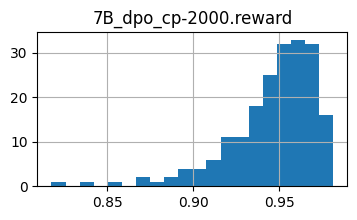

7B_baseline:
  name: 7B_baseline
  text_standard [grade]: 6.88 ± 3.08
  reading_time [s]: 3.68 ± 0.83
  toxicity [0-1]: 0.061 ± 0.191
  reward [0-1]: 0.901 ± 0.072


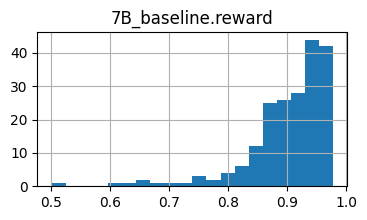

7B_cp-2000:
  name: 7B_cp-2000
  text_standard [grade]: 6.36 ± 4.94
  reading_time [s]: 3.11 ± 1.15
  toxicity [0-1]: 0.050 ± 0.163
  reward [0-1]: 0.926 ± 0.044


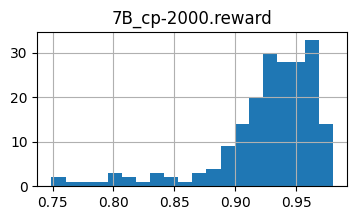

In [23]:
toxicity_pipe = pipeline("text-classification", model="tomh/toxigen_roberta")


def mean_std(col, precision=2): 
    col_mean = col.mean()
    col_std = col.std()

    return f'{col_mean:.{precision}f} ± {col_std:.{precision}f}'



def run_toxicity_pipe(text):
    try: 
        result = toxicity_pipe(text, top_k=None)
        result = [r for r in result if r['label'] == 'LABEL_1'][0]
    except:
        return 0.5

    return result['score']


metrics_list = []


for col in df.columns:

    if col == 'question':
        continue

    if not col.endswith('.answer'):
        continue

    name = col.replace('.answer', '')

    # Apply textstat functions
    text_standard = df[col].apply(lambda t: textstat.text_standard(t, float_output=True))
    reading_time = df[col].apply(textstat.reading_time)
    df[name + '.text_standard'] = text_standard
    df[name + '.reading_time'] = reading_time

    # Measure toxicity
    toxicity = df[col].apply(run_toxicity_pipe)

    # Save metrics
    metrics_list.append({
        'name': name,
        'text_standard [grade]': mean_std(text_standard),
        'reading_time [s]': mean_std(reading_time),
        'toxicity [0-1]': mean_std(toxicity, precision=3),
        'reward [0-1]': mean_std(df[name + '.reward'], precision=3),
    })

    # Print metrics
    print(f'{name}:')
    print('\n'.join([f'  {k}: {v}' for k, v in metrics_list[-1].items()]))

    # Print further info on rewards
    df[name + '.reward'].hist(bins=20, figsize=(4, 2))
    plt.title(name + '.reward')
    plt.show()


In [26]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.set_index('name').sort_index()
metrics_df.to_markdown('metrics_model_comparison.md')
metrics_df

,text_standard [grade],reading_time [s],toxicity [0-1],reward [0-1]
name,,,,
7B_baseline,6.88 ± 3.08,3.68 ± 0.83,0.061 ± 0.191,0.901 ± 0.072
7B_cp-2000,6.36 ± 4.94,3.11 ± 1.15,0.050 ± 0.163,0.926 ± 0.044
7B_dpo_cp-2000,7.70 ± 3.89,3.23 ± 0.85,0.010 ± 0.056,0.946 ± 0.026


Review an example row

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(pd.DataFrame(df.iloc[0]))

,0
question,"How does new city formation works in US? If me and my 50 friend purchase land in middle of nowhere, build homes and start living there, will it be designated as city by state government?"
7B_dpo_cp-10000.answer,Sooner or later they'll notice you. They'll come and they'll make you leave.
7B_dpo_cp-10000.reward,0.757794
7B_dpo_cp-2000.answer,"So called ""boom towns"" do indeed spring up overnight, but they're not started by 50 people. They're started by an oil company, a mining company, a logging company, a sawmill, a cattle ranch, or some similar business. The 50 people you're thinking of are called """
7B_dpo_cp-2000.reward,0.953275
7B_dpo_cp-10000.text_standard,5.0
7B_dpo_cp-10000.reading_time,0.94
7B_dpo_cp-2000.text_standard,7.0
7B_dpo_cp-2000.reading_time,3.19


#### Data for Human Annotators 

Generate sheet to compare models for human annotators. We focus on the baseline and the two checkpoints after 2500 and 8500 steps. We compare to the left and make sure that the order is randomized

In [ ]:
def encode_metadata(metadata):
    metadata = repr(metadata)
    metadata = metadata.encode('utf-8')
    metadata = base64.b64encode(metadata)
    return metadata

def decode_metadata(metadata):
    metadata = metadata[2:-1]  # remove b' and '
    metadata = base64.b64decode(metadata)
    metadata = metadata.decode('utf-8')
    metadata = ast.literal_eval(metadata)
    return metadata

In [ ]:
def create_comparison(col1, col2): 

    # Create a new dataframe with the two columns
    comparisons = []

    for i, row in df.iterrows():

        question = row['question']
        answer1 = row[col1]
        answer2 = row[col2]

        do_swap = np.random.choice([True, False])


        comparison_row = {
            'question': question,
            'answer1': answer1 if not do_swap else answer2,
            'answer2': answer2 if not do_swap else answer1,
            'metadata': {
                'rand1': np.random.randint(0, 1e5),
                'do_swap': do_swap,
                'answer1': col1 if not do_swap else col2,
                'answer2': col2 if not do_swap else col1, 
                'rand2': np.random.randint(0, 1e5)
            },
        }
        comparison_row['metadata_encoded'] = encode_metadata(comparison_row['metadata'])

        comparisons.append(comparison_row)

    df_comparisons = pd.DataFrame.from_records(comparisons)
    return df_comparisons

#with pd.option_context('display.max_colwidth', None):
#    display(create_comparison('baseline.answer', 'checkpoint-2500.answer'))

In [ ]:
df.columns

Index(['question', '7B_dpo_cp-10000.answer', '7B_dpo_cp-10000.reward',
       '7B_dpo_cp-2000.answer', '7B_dpo_cp-2000.reward',
       '7B_dpo_cp-10000.text_standard', '7B_dpo_cp-10000.reading_time',
       '7B_dpo_cp-2000.text_standard', '7B_dpo_cp-2000.reading_time'],
      dtype='object')

In [ ]:
# Yellow ones
create_comparison('3B_baseline.answer', '3B_cp-2500.answer')\
    .head(100)\
    .to_excel('Model Comparison - 3B Baseline vs 3B SFT (n100).xlsx')

create_comparison('7B_baseline.answer', '7B_cp-2000.answer')\
    .head(100)\
    .to_excel('Model Comparison - 7B Baseline vs 7B SFT (n100).xlsx')

# Green ones
create_comparison('3B_cp-2500.answer', '7B_cp-2000.answer')\
    .head(100)\
    .to_excel('Model Comparison - 3B SFT vs 7B SFT (n100).xlsx')

create_comparison('7B_cp-2000.answer', '7B-chat_cp-2500.answer')\
    .head(100)\
    .to_excel('Model Comparison - 7B SFT vs 7B Chat SFT (n100).xlsx')

# RLHF
create_comparison('7B-chat_ppo.answer', '7B-chat_cp-2500.answer')\
    .head(100)\
    .to_excel('(PPO) Model Comparison - 7B-Chat PPO vs 7B Chat SFT (n100).xlsx')

create_comparison('7B_ppo.answer', '7B_cp-2000.answer')\
    .head(100)\
    .to_excel('(PPO) Model Comparison - 7B PPO vs 7B SFT (n100).xlsx')


# create_comparison('baseline.answer', 'checkpoint-2500.answer')\
#     .to_excel('Model Comparison - Baseline vs Checkpoint-2500 (n200).xlsx')
#
# create_comparison('checkpoint-2500.answer', 'checkpoint-8500.answer')\
#     .to_excel('Model Comparison - Checkpoint-2500 vs Checkpoint-8500 (n200).xlsx')

KeyError: '3B_baseline.answer'

#### EDA on Data from Human Annotators

First, let's count the votes

In [ ]:
comparison_files = [
    'labelled_data/Model Comparison - Baseline vs Checkpoint-2500 (n200).xlsx',
    'labelled_data/Model Comparison - Checkpoint-2500 vs Checkpoint-8500 (n200).xlsx',
    'labelled_data/Model Comparison - 3B Baseline vs 3B SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B Baseline vs 7B SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B-Chat PPO vs 7B Chat SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B PPO vs 7B SFT (n100).xlsx'
]


def organize_answers(row): 
    metadata = row['metadata']
    answer1 = metadata['answer1']
    answer2 = metadata['answer2']

    return {answer1: row['answer1'], answer2: row['answer2']}


comparisons = []
answers = {}
for comparison_file in comparison_files:

    # Load comparison data
    comparison_df = pd.read_excel(comparison_file)

    # Decode metadata
    comparison_df["metadata"] = comparison_df.metadata_encoded.apply(decode_metadata)
    comparison_df.drop(columns=["metadata_encoded"], inplace=True)
    comparison_df.metadata = comparison_df.metadata.apply(lambda d: {k: v for k, v in d.items() if k not in ['rand1', 'rand2']})

    # Fix column names
    comparison_df.drop(columns=["assignee1"], inplace=True, errors="ignore")
    comparison_df.rename(columns={"label1": "label"}, inplace=True, errors="ignore")

    # Count votes
    counters = defaultdict(int)
    for _, row in comparison_df.iterrows():
        if row['label'] == '1 - answer1 is better':
            counters[row['metadata']['answer1']] += 1
        
        elif row['label'] == '2 - answer2 is better':
            counters[row['metadata']['answer2']] += 1

        elif row['label'] == '3 - both are equal':
            counters['parity'] += 1

    # Organize answers
    answers_pair = comparison_df.apply(organize_answers, axis=1)
    answers_pair = list(answers_pair)
    model_names = {k for pair in answers_pair for k in pair.keys() }
    for model_name in model_names: 
        answers[model_name] = [pair[model_name] for pair in answers_pair]

    #print(answers_pair[:2])

    counters = {name: counters[name] for name in sorted(counters.keys())}
    comparisons.append(counters)


# # Create df with answers
# answers = pd.DataFrame(answers)
# #answers.columns = [c.replace('.answer', '') for c in answers.columns]
# answers.insert(0, "question", comparison_df["question"])
#
#
# # Display
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
#     display(answers.head(3))

In [ ]:
comparisons

[{'baseline.answer': 78, 'checkpoint-2500.answer': 40, 'parity': 33},
 {'checkpoint-2500.answer': 68, 'checkpoint-8500.answer': 60, 'parity': 46},
 {'3B_baseline.answer': 16, '3B_cp-2500.answer': 53, 'parity': 31},
 {'7B_baseline.answer': 24, '7B_cp-2000.answer': 60, 'parity': 16},
 {'7B-chat_cp-2500.answer': 18, '7B-chat_ppo.answer': 19, 'parity': 15},
 {'7B_cp-2000.answer': 16, '7B_ppo.answer': 17, 'parity': 19}]

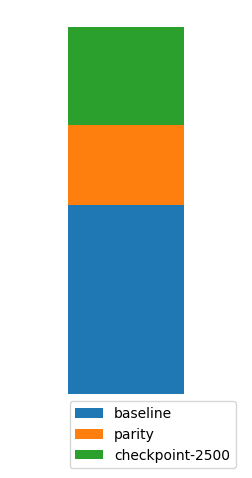

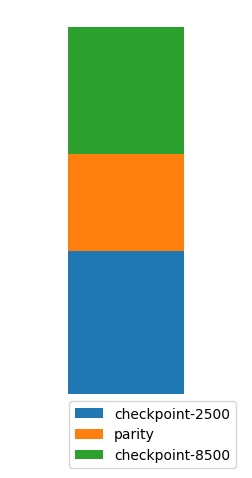

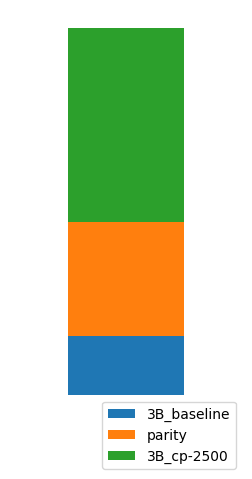

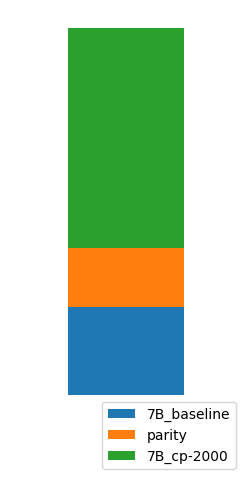

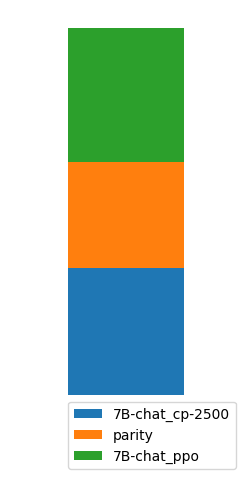

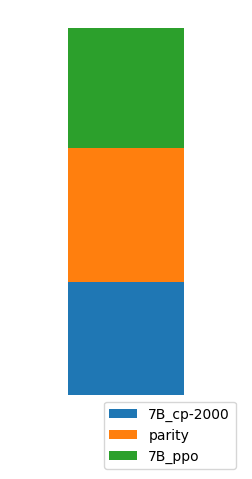

In [ ]:
for comparison in comparisons: 

    keys = list(comparison.keys())
    keys = keys[:1] + ['parity'] + keys[1:2]

    pd.DataFrame([
        {'rating': k.replace('.answer', ''), 'count': comparison[k]} for k in keys
    ]).set_index('rating').T.plot.bar(stacked=True, figsize=(3, 5), legend=False)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1.0, 0.0))
    plt.show()